### The Data is here!

Ups! Those are not images... a shame, because I already know about image processing. Well, let's take a look!


| smiles                      | target1 | target2| target3 | ... | taget12 |
|-----------------------------|---------|--------|---------|-----|---------|
|CCOc1ccc2nc(S(N)(=O)=O)sc2c1 |    0    |    0   |    1    | ... |    0    |

Seems like we have the [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) representation of some molecules and values for certain targets. The targets values are binary: 0 or 1.

Let's see if we can predict the value of **target1** just using the SMILES we have. Doesn't sound like a bad plan, but we don't know much about molecules, but well, text processing is a huge field in machine learning and a SMILES is a string representation of a molecule.

So, when we are learning "sentences" (like, for example, in sentiment analysis), we don't care only about the words as separate units, but also about the context. The meaning of a word might change depending on the previous or the next word or words. It sounds like we want something similar with our SMILES, we don't care only about an atom, or a character, in the SMILE, we care about the context. One of the techniques for predicting categories based on analyzing words and it context is using Recurrent Neural Netwoks (For a little overview about RNN and how they work, I read this [article](https://karpathy.github.io/2015/05/21/rnn-effectiveness/?fbclid=IwAR3hdJeXQV9_I1fHGlFNuB_pK5pcQX8lc-T0NPOMjt87gDITH3Mw-fJXSow) from Andrej Karpathy, who is the director of artificial intelligence and Autopilot Vision at Tesla and he specializes in deep learning and image recognition and understanding).

First things first. We have to read the data!


In [21]:
import csv

def get_data():
    targets_keys = ["target1", "target2", "target3", "target4", "target5",
                    "target6", "target7", "target8", "target9", "target10",
                    "target11", "target12"]
    smiles_dict = {}
    with open("data.csv") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            row_targets = []
            for key in targets_keys:
                row_targets.append(row[key])
            smiles_dict["smiles"] = row_targets
    return smiles_dict

Let's take a look at the content of our data:

In [23]:
import random as rd
import numpy as np
np.random.seed(7)

data = get_data()
smiles, targets = rd.choice(list(data.items()))
print(smiles, targets)

smiles ['0', '0', '', '0', '0', '0', '0', '0', '0', '0', '1', '0']


### 1st Problem: Missing Data

Well well well... tha value for the 3rd target is empty. That is bad news, it means that we have missing data in our dataset. Let's find out how much data we are missing for each target.

In [24]:
def get_targets():
    targets_keys = ["target1", "target2", "target3", "target4", "target5",
                    "target6", "target7", "target8", "target9", "target10",
                    "target11", "target12"]
    targets = []
    with open("data.csv") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            row_targets = []
            for key in targets_keys:
                row_targets.append(row[key])
            targets.append(row_targets)
    n_targets = []
    for target in targets:
        n_targets.append([float(i) if i != "" else None for i in target])
    return n_targets

In [25]:
targets = get_targets()
counter = np.zeros(12)
for target in targets:
    for i in range(len(target)):
        if target[i] is None:
            counter[i] += 1
print(counter)

[ 575. 1112. 1323. 2074. 1698.  902. 1431. 2079.  782. 1420. 2094. 1105.]


Wow! for some columns we are missing more than 2000 values! That's a lot of data!

Worry don't yet. We can face this problem in several ways:
- We could remove the rows where we have empty fields
- We could use statistics measures to fill the empty spaces (mode, mean, median)
- We could try to "predict" the missing values

We are not trying the first approach, as we already have only 8k of data, we decided not to follow any technique implying to decrease the size of the data-set.

Even when we think the 3rd option is the best one, for now, we are gonna go with the second one, in order to save time. If at the end we have any time left, we will try the 3rd approach.

The first thing we are gonna do is to check how many 0s and 1s we have for each target:

In [26]:
ones_counter = np.zeros(12)
zeros_counter = np.zeros(12)
for target in targets:
    for i in range(len(target)):
        if target[i] is not None:
            if target[i] == 1:
                ones_counter[i] += 1
            else:
                zeros_counter[i] += 1
print("Number of 1s per target:")
print(ones_counter)
print("")
print("Number of 0s per target:")
print(zeros_counter)

Number of 1s per target:
[310. 238. 785. 307. 798. 356. 189. 961. 267. 379. 936. 431.]

Number of 0s per target:
[7129. 6664. 5906. 5633. 5518. 6756. 6394. 4974. 6965. 6215. 4984. 6478.]


From the result above is easy to notice that, for this data-set, the mean is below 0.5 and the mode and the median are both 0, for all the targets. So, following our second criteria, we are gonna fill all the missing values with 0s.

In [27]:
def fill_targets():
    """
    This function fills all the missing values in the targets with 0s
    """
    targets = get_targets()
    for target in targets:
        for i in range(len(target)):
            if target[i] is None:
                target[i] = 0.0
    return targets

### 2nd problem: SMILES representation

Now we can do our fisrt attempt of using a RNN for learning to predict the targets. In order to do that, we need to transform our data into numerical vectors.

However, there is something we must consider first: could it happen that two different SMILES represent the same molecule? After a little bit of search, we found out that, in fact, is a very possible thing. A simple way to target this problem is to use any SMILES toolkit for python to transform our SMILES into their "canonical form". SMILES doesn't have a canonical form per se, but every toolkit for managing SMILES have it's own canonical representation, which is all what we need.

To target this problem, we used the **rdkit** library. The **rdkit** library needs to be installed using conda and it's not included into our current virtualenv, so the code to generate the canonical version of the SMILES is posted here just as reference, but it's included into the project and the file "canonized_smiles.txt" represents it's output:

```python
from rdkit import Chem
import csv
import numpy as np

"""
This script reads the data from the data.csv file and uses rdkit
to canonize all the smiles.
Also, creates a list with 12 elements for each row with the values of
the targets and, for the empty target values, it creates a new target array
with all the possible values.
Finally, it saves the list with all the canonized smiles, the
list with all the lists of targets and an augmentd list of canonized smiles
into .npy files.
"""
def get_smiles_and_targets():
    """
    Reads data from the data.csv file and returns two arrays of equal lenght
    Output:
            smiles: the rdkit representation of every smiles in the original
                    data
            targets: an array of arrays with the values for every one of the
                    12 targets
    """
    targets_keys = ["target1", "target2", "target3", "target4", "target5",
                    "target6", "target7", "target8", "target9", "target10",
                    "target11", "target12"]
    smiles = []
    targets = []
    with open("data.csv") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            smiles.append(Chem.MolToSmiles(Chem.MolFromSmiles(row["smiles"])))
            row_targets = []
            for key in targets_keys:
                row_targets.append(row[key])
            targets.append(row_targets)
    return smiles, targets

def save_smiles():
    """
    Saves the smile representation from rdkit into a .txt file
    """
    smiles, _ = get_smiles_and_targets()
    with open("canonized_smiles.txt", 'w') as f:
        for i in smiles:
            f.write(i + '\n')

save_smiles()
``` 

Now, we can be sure that we will not "learn" as two different cases, two different representations of the same molecule. 

Let's just do one more step: to decide how to map the data. The simplest way to map a SMILES representation into an integers vector, is to map every character to an specific integer. Obviously, any representation that allow us to keep more infomation about the original structure of the data, would be more helpfull than this. Different approaches can be used to improve the data representation, but, as a grammar definition is followed to represent moleccules as SMILES, we choose to transform the SMILES representation into tokens of that grammar.

The file script **smiles_lexer.py** contains the code to represent the SMILES's grammar and to tokenize a specific SMILES. We used the python **ply** library for defining the grammar.

In [28]:
from smiles_lexer import tokenize_smiles

def get_tokens_dict():
    st_dict = {}
    with open("canonized_smiles.txt", 'r') as f:
        smiles = [line.rstrip('\n') for line in f]
    index = 2
    for smile in smiles:
        tokenized_smile = list(tokenize_smiles(smile))
        for token in tokenized_smile:
            if not token in st_dict:
                st_dict[token] = index
                index += 1
    return st_dict

def get_smiles_as_vectors():
    with open("canonized_smiles.txt", 'r') as f:
        smiles = [line.rstrip('\n') for line in f]
    tokens_dict = get_tokens_dict()
    r = []
    for smile in smiles:
        vector = []
        tokens = list(tokenize_smiles(smile))
        for token in tokens:
            vector.append(tokens_dict[token])
        r.append(vector)
    return r

Now, we have our data organized enough as to be able to do our fisrt learning attemp. Let's try to teach a RNN model to predict given a cetain SMILES, it result for **target1**.

Train
Build model


/home/amy/Documents/reid_project/env/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/amy/Documents/reid_project/env/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, 1))`


Train on 6411 samples, validate on 1603 samples
Epoch 1/10
6411/6411 [==============================] - 25s 4ms/step - loss: 0.2002 - acc: 0.9579 - val_loss: 0.1784 - val_acc: 0.9563
Epoch 2/10
6411/6411 [==============================] - 30s 5ms/step - loss: 0.1588 - acc: 0.9626 - val_loss: 0.1774 - val_acc: 0.9563
Epoch 3/10
6411/6411 [==============================] - 27s 4ms/step - loss: 0.1589 - acc: 0.9626 - val_loss: 0.1749 - val_acc: 0.9563
Epoch 4/10
6411/6411 [==============================] - 25s 4ms/step - loss: 0.1561 - acc: 0.9626 - val_loss: 0.1725 - val_acc: 0.9563
Epoch 5/10
6411/6411 [==============================] - 26s 4ms/step - loss: 0.1520 - acc: 0.9626 - val_loss: 0.1647 - val_acc: 0.9563
Epoch 6/10
6411/6411 [==============================] - 27s 4ms/step - loss: 0.1481 - acc: 0.9626 - val_loss: 0.1622 - val_acc: 0.9563
Epoch 7/10
6411/6411 [==============================] - 26s 4ms/step - loss: 0.1478 - acc: 0.9626 - val_loss: 0.1614 - val_acc: 0.9563
Epoch 8

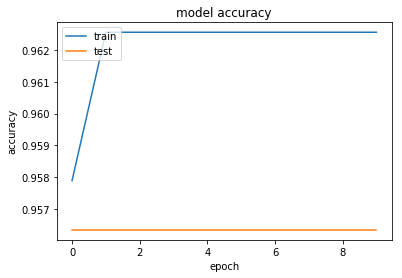

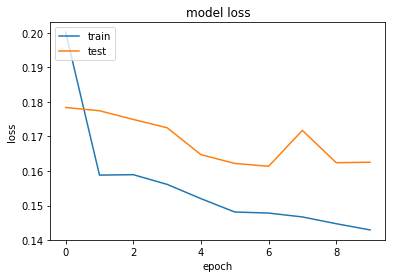

In [29]:
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing import sequence
from keras.utils import to_categorical
np.random.seed(7)

def training_data(x_train, y):
    max_len = len(max(x_train, key=len))
    x_train = sequence.pad_sequences(x_train, maxlen=max_len)
    x = [[[float(i)] for i in x] for x in x_train]
    x = np.array(x)
    x = x.reshape(x.shape[0], max_len, 1)
    y = np.array(y)
    y = to_categorical(y, 2)
    spl = (len(x_train)*80)//100
    x_train, x_test = np.array(x[0:spl]), np.array(x[spl:])
    y_train, y_test = np.array(y[0:spl]), np.array(y[spl:])
    return x_train, x_test, y_train, y_test

def build_model():
    print("Build model")
    model = Sequential()
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, input_dim=1))
    model.add(Dense(2, activation="sigmoid"))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    return model

def show_metrics(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

smiles = get_smiles_as_vectors()
target_index = 0
target = [target[target_index] for target in fill_targets()]
x, y = smiles, target

print("Train")
x_train, x_test, y_train, y_test = training_data(x, y)
model = build_model()
history= model.fit(x_train, y_train,
                epochs=10,
                validation_data=(x_test, y_test),
                verbose=1)

scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

show_metrics(history)


As you can see above, the accuracy obtained for the model is pretty high, but is not changing during training and the learning curves are not looking good. Let's check what is really going on. We can start by computing the variables needed to find out the precision and recall values:

In [30]:
def get_target_values(categories):
    values = []
    for pair in categories:
        if pair[0] > 0.5:
            values.append(0.0)
        else:
            values.append(1.0)
    return values

def evaluation_variables(predicted, expected):
    """
    :returns a tuple: true_positives, true_negatives, false_positives, false_negatives
    """
    t_p, t_n, f_p, f_n = 0, 0, 0, 0
    for i in range(len(predicted)):
        if predicted[i] == 1 and expected[i] == 1:
            t_p += 1
        elif predicted[i] == 1 and expected[i] != 1:
            f_p += 1
        elif predicted[i] == 0 and expected[i] == 0:
            t_n += 1
        else:
            f_n += 1
    return t_p, t_n, f_p, f_n


predicted = get_target_values(model.predict(x_test, verbose=1))
expected = get_target_values(y_test)

t_p, t_n, f_p, f_n = evaluation_variables(predicted, expected)

print("")
print("True Positives: %i" %t_p)
print("True Negatives: %i" %t_n)
print("False Positives: %i" %f_p)
print("False Negatives: %i" %f_n)



1603/1603 [==============================] - 1s 921us/step

True Positives: 0
True Negatives: 1533
False Positives: 0
False Negatives: 70


### 3rd Problem: Balancing Data

The explanation here is pretty obvious: our classifier learned to classify any element as negative. There is not a single output for the evaluation set with a positive value.

To explore why this happened, let's look into the percent that positives values represent for every target:

In [31]:
def positives_proportion():
    targets = get_targets()
    ones_counter = np.zeros(12)
    zeros_counter = np.zeros(12)
    for target in targets:
        for i in range(len(target)):
            if target[i] is not None:
                if target[i] == 1:
                    ones_counter[i] += 1
                else:
                    zeros_counter[i] += 1
    return ones_counter * 100 / (ones_counter + zeros_counter)

print(positives_proportion())

[ 4.16722678  3.44827586 11.73217755  5.16835017 12.63457885  5.0056243
  2.87103144 16.19208088  3.69192478  5.74764938 15.81081081  6.23823998]


As you can see above, the data is very imbalanced. For **target1**, the number of positives cases represent only a 4.16% of the total of cases. The biggest proportion of positive cases is for **target8**, with a 16.19%.

There's, again, different ways to target this problem. A common way is undersampling your data, if your data-set is too large, or oversampling your data, if the data-set isn't that large. There's another powerful technique, wich is to generate synthetic samples. SMOTE or the Synthetic Minority Over-sampling Technique, is one of the must popular algorithms to do that. [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) is a python library for balancing data-sets, we didn't have the time to try it, but using SMOTE and other "balancing" algorithms included in this library is one of the thing s that could potencially help to improve our results.

For now, let's try oversampling our positive cases.

In [40]:
import utils

def get_positive_samples(target_index, smiles, targets):
    positive_smiles = []
    for i in range(len(targets)):
        if targets[i][target_index]:
            positive_smiles.append(smiles[i])
    return positive_smiles

def over_sampling_data_set(target_index, positive_samples, smiles, target):
    smiles, target = smiles.copy(), target.copy()
    positives, negatives = utils.targets_mode()
    ratio = negatives[target_index] - positives[target_index]
    while ratio > 0:
        vector = rd.choice(positive_samples)
        index = rd.randint(0, len(target)-1)
        smiles.insert(index, vector)
        target.insert(index, 1.0)
        ratio -= 1
    return smiles, target

And let's evaluate our model with the augmented dat-set.

6819.0
8014
14833
14833
Train
Build model


/home/amy/Documents/reid_project/env/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/amy/Documents/reid_project/env/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, 1))`


Train on 11866 samples, validate on 2967 samples
Epoch 1/10
11866/11866 [==============================] - 53s 4ms/step - loss: 0.6146 - acc: 0.6554 - val_loss: 0.5355 - val_acc: 0.7236
Epoch 2/10
11866/11866 [==============================] - 48s 4ms/step - loss: 0.5558 - acc: 0.7127 - val_loss: 0.5236 - val_acc: 0.7354
Epoch 3/10
11866/11866 [==============================] - 47s 4ms/step - loss: 0.5498 - acc: 0.7145 - val_loss: 0.5498 - val_acc: 0.7378
Epoch 4/10
11866/11866 [==============================] - 46s 4ms/step - loss: 0.5519 - acc: 0.7195 - val_loss: 0.5874 - val_acc: 0.6815
Epoch 5/10
11866/11866 [==============================] - 48s 4ms/step - loss: 0.5401 - acc: 0.7247 - val_loss: 0.5403 - val_acc: 0.7300
Epoch 6/10
11866/11866 [==============================] - 47s 4ms/step - loss: 0.5350 - acc: 0.7243 - val_loss: 0.5123 - val_acc: 0.7368
Epoch 7/10
11866/11866 [==============================] - 47s 4ms/step - loss: 0.5325 - acc: 0.7242 - val_loss: 0.5368 - val_acc:

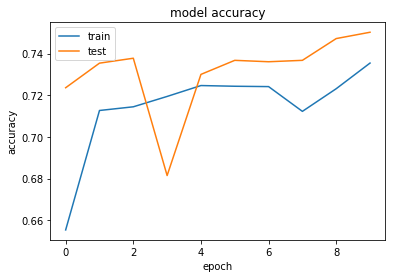

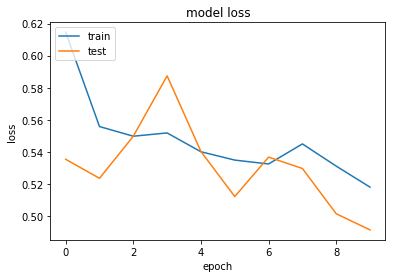

In [39]:
positive_samples = get_positive_samples(target_index, smiles, fill_targets())
x_train, y = over_sampling_data_set(0, positive_samples, smiles, target)

x_train, x_test, y_train, y_test = training_data(x_train, y)

print("Train")
model = build_model()
history= model.fit(x_train, y_train,
                epochs=10,
                validation_data=(x_test, y_test),
                verbose=1)

scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

show_metrics(history)

Now it looks a bit better, let's check the accuracy, precision and recall of the model.

In [46]:
predicted = get_target_values(model.predict(x_test, verbose=1))
expected = get_target_values(y_test)

t_p, t_n, f_p, f_n = evaluation_variables(predicted, expected)

print("")
print("True Positives: %i" %t_p)
print("True Negatives: %i" %t_n)
print("False Positives: %i" %f_p)
print("False Negatives: %i" %f_n)
print("")
print("Accuracy: %f" %((t_p + t_n)/(t_p + t_n + f_p + f_n)))
print("Precision: %f" %(t_p/(t_p + f_p)))
print("Recall: %f" %(t_p/(t_p + f_n)))

2967/2967 [==============================] - 2s 749us/step

True Positives: 710
True Negatives: 1518
False Positives: 69
False Negatives: 670

Accuracy: 0.750927
Precision: 0.911425
Recall: 0.514493


We got a really high presicion! But as we are trying to determinate the toxicity of a molecule, is the recall what we care more about, as recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative. In an attempt to improve recall, let's add a convolutional and a pooling layer to our model, in order to improve the features learning.

Train
Build model


/home/amy/Documents/reid_project/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
/home/amy/Documents/reid_project/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, 1))`
  if __name__ == '__main__':


Train on 11866 samples, validate on 2967 samples
Epoch 1/10
11866/11866 [==============================] - 31s 3ms/step - loss: 0.5963 - acc: 0.6808 - val_loss: 0.5431 - val_acc: 0.7300
Epoch 2/10
11866/11866 [==============================] - 32s 3ms/step - loss: 0.5378 - acc: 0.7337 - val_loss: 0.5184 - val_acc: 0.7472
Epoch 3/10
11866/11866 [==============================] - 30s 3ms/step - loss: 0.5191 - acc: 0.7422 - val_loss: 0.5031 - val_acc: 0.7519
Epoch 4/10
11866/11866 [==============================] - 41s 3ms/step - loss: 0.5031 - acc: 0.7494 - val_loss: 0.4921 - val_acc: 0.7594
Epoch 5/10
11866/11866 [==============================] - 36s 3ms/step - loss: 0.4919 - acc: 0.7529 - val_loss: 0.4809 - val_acc: 0.7590
Epoch 6/10
11866/11866 [==============================] - 33s 3ms/step - loss: 0.4823 - acc: 0.7614 - val_loss: 0.4641 - val_acc: 0.7779
Epoch 7/10
11866/11866 [==============================] - 31s 3ms/step - loss: 0.4712 - acc: 0.7704 - val_loss: 0.4615 - val_acc:

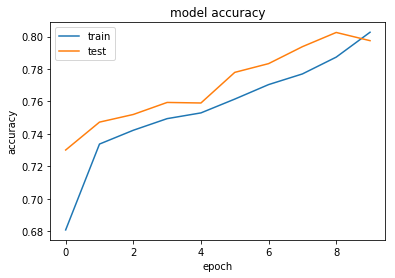

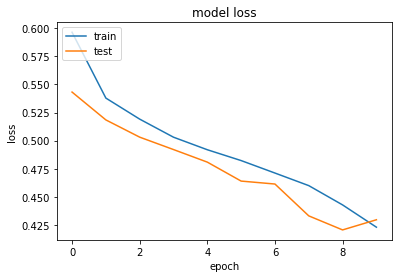

In [48]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

def build_cnn_model():
    print("Build model")
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, input_dim=1))
    model.add(Dense(2, activation="sigmoid"))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    return model

print("Train")
model = build_cnn_model()
history= model.fit(x_train, y_train,
                epochs=10,
                validation_data=(x_test, y_test),
                verbose=1)

scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

show_metrics(history)

In [49]:
predicted = get_target_values(model.predict(x_test, verbose=1))
expected = get_target_values(y_test)

t_p, t_n, f_p, f_n = evaluation_variables(predicted, expected)

print("")
print("True Positives: %i" %t_p)
print("True Negatives: %i" %t_n)
print("False Positives: %i" %f_p)
print("False Negatives: %i" %f_n)
print("")
print("Accuracy: %f" %((t_p + t_n)/(t_p + t_n + f_p + f_n)))
print("Precision: %f" %(t_p/(t_p + f_p)))
print("Recall: %f" %(t_p/(t_p + f_n)))

2967/2967 [==============================] - 2s 601us/step

True Positives: 1259
True Negatives: 686
False Positives: 901
False Negatives: 121

Accuracy: 0.655544
Precision: 0.582870
Recall: 0.912319


Now we got a better recall value!

What we want to do next is to build a model that takes into account the possible correlation between the targets to improve the accuracy of our predictions. Let's find out if there are some symptoms of correlation in our data-set. If we look carefully, we find cases like this:

```
Nc1ccc(-c2ccc(N)cc2)cc1
['0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0']
['0', '0', '1', '' , '' , '0', '0', '1', '1', '0', '1', '0']
```

Notice that for the same molecule, the value of **target3**, **target8**, **target9** and **target11** is different, so it could be possible that some target values actually have influence in other target values. 

What we are going to do, is to add a the vector with the complementary targets to our input, so the network can "learn" their influence.

Train
Build model


/home/amy/Documents/reid_project/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
/home/amy/Documents/reid_project/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, 1))`
  if __name__ == '__main__':


Train on 11866 samples, validate on 2967 samples
Epoch 1/10
11866/11866 [==============================] - 32s 3ms/step - loss: 0.5887 - acc: 0.6896 - val_loss: 0.5125 - val_acc: 0.7378
Epoch 2/10
11866/11866 [==============================] - 31s 3ms/step - loss: 0.5069 - acc: 0.7495 - val_loss: 0.5146 - val_acc: 0.7597
Epoch 3/10
11866/11866 [==============================] - 31s 3ms/step - loss: 0.4792 - acc: 0.7702 - val_loss: 0.4518 - val_acc: 0.7826
Epoch 4/10
11866/11866 [==============================] - 32s 3ms/step - loss: 0.4596 - acc: 0.7806 - val_loss: 0.4395 - val_acc: 0.7877
Epoch 5/10
11866/11866 [==============================] - 32s 3ms/step - loss: 0.4460 - acc: 0.7890 - val_loss: 0.4458 - val_acc: 0.7910
Epoch 6/10
11866/11866 [==============================] - 31s 3ms/step - loss: 0.4319 - acc: 0.7993 - val_loss: 0.4120 - val_acc: 0.8049
Epoch 7/10
11866/11866 [==============================] - 32s 3ms/step - loss: 0.4194 - acc: 0.8068 - val_loss: 0.3969 - val_acc:

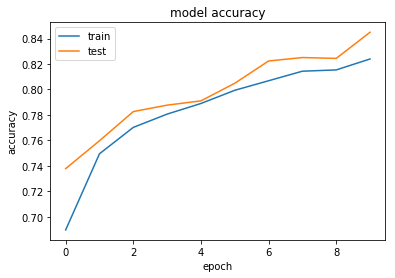

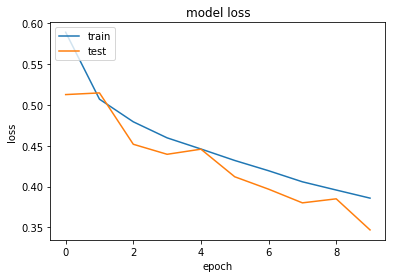

In [53]:
smiles = get_smiles_as_vectors()
original_targets = fill_targets()
target_index = 0

target = [target[target_index] for target in original_targets]
targets_vector = [[target[i] for i in range(
    len(target)) if i != target_index] for target in original_targets]
smiles = [smiles[i] + targets_vector[i] for i in range(len(smiles))]

positive_samples = get_positive_samples(target_index, smiles, fill_targets())
x_train, y = over_sampling_data_set(0, positive_samples, smiles, target)

x_train, x_test, y_train, y_test = training_data(x_train, y)

print("Train")
model = build_cnn_model()
history= model.fit(x_train, y_train,
                epochs=10,
                validation_data=(x_test, y_test),
                verbose=1)

scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

show_metrics(history)

In [56]:
predicted = get_target_values(model.predict(x_test, verbose=1))
expected = get_target_values(y_test)

t_p, t_n, f_p, f_n = evaluation_variables(predicted, expected)

print("")
print("True Positives: %i" %t_p)
print("True Negatives: %i" %t_n)
print("False Positives: %i" %f_p)
print("False Negatives: %i" %f_n)
print("")
print("Accuracy: %f" %((t_p + t_n)/(t_p + t_n + f_p + f_n)))
print("Precision: %f" %(t_p/(t_p + f_p)))
print("Recall: %f" %(t_p/(t_p + f_n)))

2967/2967 [==============================] - 2s 547us/step

True Positives: 1419
True Negatives: 124
False Positives: 1402
False Negatives: 22

Accuracy: 0.520054
Precision: 0.503013
Recall: 0.984733


Let's now feed the network with our original data:

In [60]:
max_len = len(max(smiles, key=len))
x_train = sequence.pad_sequences(smiles, maxlen=max_len)
x = [[[float(i)] for i in x] for x in x_train]
x = np.array(x)
x = x.reshape(x.shape[0], max_len, 1)
y = np.array(y)

predicted = get_target_values(model.predict(x, verbose=1))

t_p, t_n, f_p, f_n = evaluation_variables(predicted, y)

print("")
print("True Positives: %i" %t_p)
print("True Negatives: %i" %t_n)
print("False Positives: %i" %f_p)
print("False Negatives: %i" %f_n)
print("")
print("Accuracy: %f" %((t_p + t_n)/(t_p + t_n + f_p + f_n)))
print("Precision: %f" %(t_p/(t_p + f_p)))
print("Recall: %f" %(t_p/(t_p + f_n)))

8014/8014 [==============================] - 4s 549us/step

True Positives: 3556
True Negatives: 310
False Positives: 3851
False Negatives: 297

Accuracy: 0.482406
Precision: 0.480086
Recall: 0.922917
